In [178]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
AirData_16to19_Df = pd.read_csv(r"G:\Uppsala Docs\period5&6\ProcessedData\2016-2019_sensorData.csv",usecols=['Stop', 'Station Name', 'NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'Classification', 'PM10'])

In [3]:
# Rename Stop to Time
AirData_16to19_Df = AirData_16to19_Df.rename(columns={"Stop": "Timestamp"})
# convert columns to date
AirData_16to19_Df['Timestamp'] = pd.to_datetime(AirData_16to19_Df['Timestamp'])
AirData_16to19_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371806 entries, 0 to 371805
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       371806 non-null  datetime64[ns]
 1   Station Name    371806 non-null  object        
 2   NO2             366946 non-null  float64       
 3   NOX as NO2      367291 non-null  float64       
 4   PM2.5           149643 non-null  float64       
 5   CO              204391 non-null  float64       
 6   Black Carbon    55003 non-null   float64       
 7   O3              58058 non-null   float64       
 8   Classification  371806 non-null  object        
 9   PM10            224719 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 28.4+ MB


In [4]:
AirData_16to19_Df.describe()

,NO2,NOX as NO2,PM2.5,CO,Black Carbon,O3,PM10
count,366946.000000,367291.000000,149643.000000,204391.000000,55003.000000,58058.000000,224719.000000
mean,25.683851,50.386642,5.778358,0.304097,0.650116,44.984455,18.942042
std,20.804096,57.503800,4.763950,0.238521,0.637904,22.205009,20.372545
min,-0.300000,-0.500000,-3.000000,0.000000,0.000000,0.100000,-3.040000
25%,9.800000,12.700000,2.700000,0.210000,0.209000,28.600000,7.800000
50%,19.700000,29.200000,4.600000,0.290000,0.444000,43.900000,13.200000
75%,36.200000,66.800000,7.600000,0.360000,0.891000,59.800000,22.200000
max,221.700000,1075.800000,105.000000,20.700000,30.400000,151.200000,403.900000


## 1) Feature selection

In [5]:
# Percentage of empty rows in each pollutant
total = AirData_16to19_Df.isnull().sum().sort_values(ascending = False)
print("Empty rows in each pollutant:")
total / len(AirData_16to19_Df) * 100

Empty rows in each pollutant:


Black Carbon      85.206532
O3                84.384867
PM2.5             59.752398
CO                45.027514
PM10              39.560147
NO2                1.307133
NOX as NO2         1.214343
Classification     0.000000
Station Name       0.000000
Timestamp          0.000000
dtype: float64

In [6]:
# Percentage of Non-zero or Non-negative rows in each pollutant
total = (AirData_16to19_Df[['NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'PM10']] >= 0).sum().sort_values(ascending = True)
print("Non-zero or Non-negative rows in each pollutant:")
total / len(AirData_16to19_Df) * 100

Non-zero or Non-negative rows in each pollutant:


Black Carbon    14.793468
O3              15.615133
PM2.5           39.255956
CO              54.972486
PM10            60.100429
NO2             98.692598
NOX as NO2      98.784850
dtype: float64

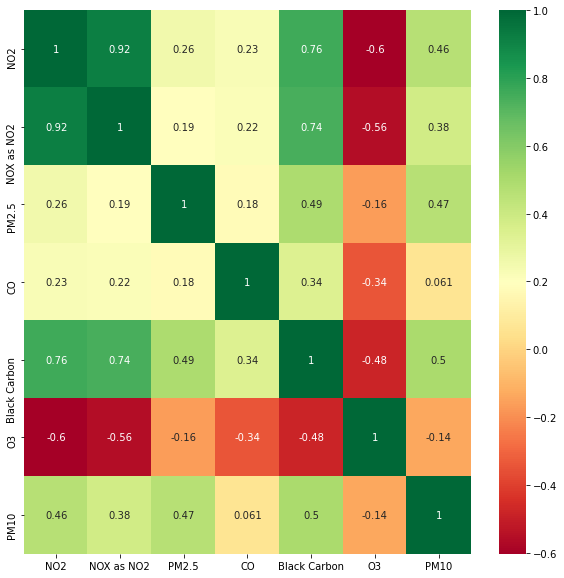

In [7]:
# correlation Matrix with Heatmap
# get correlations of each features in dataset
corrmat = AirData_16to19_Df[['NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'PM10']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# plot heat map
g=sns.heatmap(AirData_16to19_Df[['NO2', 'NOX as NO2', 'PM2.5', 'CO','Black Carbon', 'O3', 'PM10']][top_corr_features].corr(),annot=True,cmap="RdYlGn")

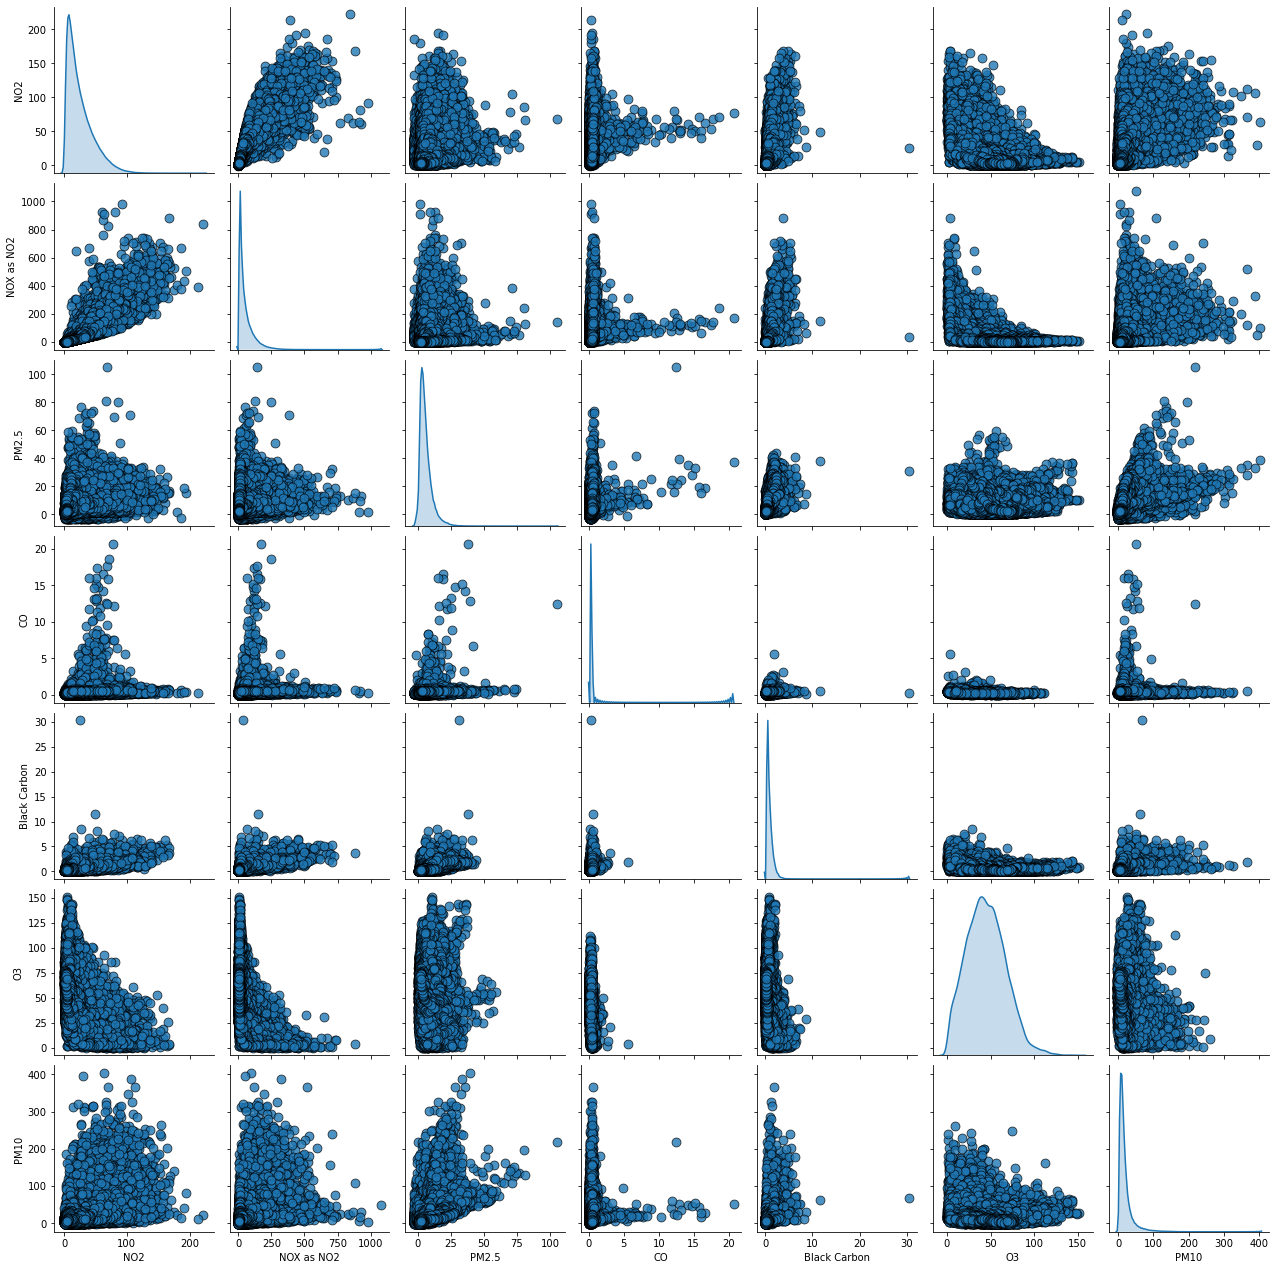

In [165]:
sns.pairplot(AirData_16to19_Df, diag_kind="kde", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'})

### Features Selected Based On Above analysis: 
#### 'NO2', 'NOX as NO2', 'PM2.5', 'PM10'

In [9]:
# updating data
AirData_1 = AirData_16to19_Df[['Timestamp', 'Station Name', 'Classification', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
AirData_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371806 entries, 0 to 371805
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       371806 non-null  datetime64[ns]
 1   Station Name    371806 non-null  object        
 2   Classification  371806 non-null  object        
 3   NO2             366946 non-null  float64       
 4   NOX as NO2      367291 non-null  float64       
 5   PM2.5           149643 non-null  float64       
 6   PM10            224719 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 19.9+ MB


## 2) Station Selection

In [10]:
# Generating Year and droppng 2020 data
AirData_1['Year'] = AirData_1['Timestamp'].dt.year
# drop 2020 data
AirData_1 = AirData_1[AirData_1['Year'] !=  2020]
AirData_1.info()

E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 371795 entries, 0 to 371804
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       371795 non-null  datetime64[ns]
 1   Station Name    371795 non-null  object        
 2   Classification  371795 non-null  object        
 3   NO2             366935 non-null  float64       
 4   NOX as NO2      367280 non-null  float64       
 5   PM2.5           149638 non-null  float64       
 6   PM10            224712 non-null  float64       
 7   Year            371795 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 25.5+ MB


In [11]:
# Data distribution for selecting station
stationSelectGroups = AirData_1.groupby(['Year', 'Station Name']).aggregate('count').drop(['Timestamp','Classification'],1)
stationSelectGroups

NO2  NOX as NO2  PM2.5  PM10
Year Station Name                                                    
2016 #Stockholm E4/E20 Lilla Essingen   8737        8737   8561  8612
     #Stockholm Folkungagatan 57        7764        7764      0  7704
     #Stockholm Hornsgatan 108 Gata     8709        8711   8763  8658
     #Stockholm Hornsgatan 108 Tak      8715        8727      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8722        8723      0     0
     #Stockholm Norrlandsgatan 29       8779        8779      0  8761
     #Stockholm Sveavägen 59 Gata       8756        8758   8413  8630
     #Stockholm Sveavägen 59 Tak        8736        8758      0     0
     #Stockholm Sveavägen 88 Gata       8756        8758      0     0
     #Stockholm Torkel Knutssongatan    8746        8746   8737  8552
2017 #Stockholm E4 Skonertvägen         4685        4689      0  4644
     #Stockholm E4/E20 Lilla Essingen   8741        8742   8593  8654
     #Stockholm Folkungagatan 57        8628        8628      0  8620
     #Stockholm Hornsgatan 108 Gata     8661        8664   8517  8359
     #Stockholm Hornsgatan 108 Tak      8639        8645      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8657        8665      0     0
     #Stockholm Norrlandsgatan 29       8661        8662      0  8546
     #Stockholm Sveavägen 59 Gata       8712        8735   7058  7367
     #Stockholm Sveavägen 59 Tak        8709        8736      0     0
     #Stockholm Sveavägen 88 Gata       8736        8735      0     0
     #Stockholm Torkel Knutssongatan    8725        8726   8716  8564
2018 #Stockholm E4 Skonertvägen         8752        8755      0  8693
     #Stockholm E4/E20 Lilla Essingen   8587        8587   8452  8546
     #Stockholm Folkungagatan 57        1453        1453      0  1450
     #Stockholm Folkungagatan 70        6533        6548      0  6477
     #Stockholm Hornsgatan 108 Gata     8663        8695   8252  7750
     #Stockholm Hornsgatan 108 Tak      8706        8709      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8701        8707      0     0
     #Stockholm Norrlandsgatan 29          1           1      0     1
     #Stockholm St Eriksgatan 83        8456        8456   8699  8699
     #Stockholm Sveavägen 59 Gata       8628        8633   7438  8553
     #Stockholm Sveavägen 59 Tak        8657        8690      0     0
     #Stockholm Sveavägen 88 Gata       8685        8697      0     0
     #Stockholm Torkel Knutssongatan    8572        8573   8636  8450
2019 #Stockholm E4 Skonertvägen         8449        8437      0  8634
     #Stockholm E4/E20 Lilla Essingen   8685        8662   8429  8528
     #Stockholm Folkungagatan 70        8721        8725      0  8657
     #Stockholm Hornsgatan 108 Gata     8711        8685   8755  8755
     #Stockholm Hornsgatan 108 Tak      8735        8735      0     0
     #Stockholm Hornsgatan 85 Gatunivå  8654        8660      0     0
     #Stockholm St Eriksgatan 83        8572        8571   8704  8704
     #Stockholm Sveavägen 59 Gata       8392        8557   8546  8673
     #Stockholm Sveavägen 59 Tak        8324        8332      0     0
     #Stockholm Sveavägen 88 Gata       8625        8625      0     0
     #Stockholm Torkel Knutssongatan    8699        8699   6369  8471

In [12]:
# filtering stations based on data avaliable (Greater than 0 on all selected pollutants across year)
print("Combinations:")
print(stationSelectGroups[stationSelectGroups.all(1)].index)
print("Stations:")
print(stationSelectGroups[stationSelectGroups.all(1)].index.unique(1))

Combinations:
MultiIndex([(2016, '#Stockholm E4/E20 Lilla Essingen'),
            (2016,   '#Stockholm Hornsgatan 108 Gata'),
            (2016,     '#Stockholm Sveavägen 59 Gata'),
            (2016,  '#Stockholm Torkel Knutssongatan'),
            (2017, '#Stockholm E4/E20 Lilla Essingen'),
            (2017,   '#Stockholm Hornsgatan 108 Gata'),
            (2017,     '#Stockholm Sveavägen 59 Gata'),
            (2017,  '#Stockholm Torkel Knutssongatan'),
            (2018, '#Stockholm E4/E20 Lilla Essingen'),
            (2018,   '#Stockholm Hornsgatan 108 Gata'),
            (2018,      '#Stockholm St Eriksgatan 83'),
            (2018,     '#Stockholm Sveavägen 59 Gata'),
            (2018,  '#Stockholm Torkel Knutssongatan'),
            (2019, '#Stockholm E4/E20 Lilla Essingen'),
            (2019,   '#Stockholm Hornsgatan 108 Gata'),
            (2019,      '#Stockholm St Eriksgatan 83'),
            (2019,     '#Stockholm Sveavägen 59 Gata'),
            (2019,  '#Stockholm To

### Stations Selected:
#### 2016 - 2019:
##### 1.Stockholm E4/E20 Lilla Essingen, 2.Stockholm Hornsgatan 108 Gata, 3.Stockholm Sveavägen 59 Gata, 4.Stockholm Torkel Knutssongatan
#### 2018 - 2019: 
##### 1.Stockholm E4/E20 Lilla Essingen, 2.Stockholm Hornsgatan 108 Gata, 3.Stockholm St Eriksgatan 83, 4.Stockholm Sveavägen 59 Gata, 5.Stockholm Torkel Knutssongatan

In [13]:
# updating data
AirData_2 = AirData_1.loc[(AirData_1['Station Name'] == "#Stockholm E4/E20 Lilla Essingen") |
                          (AirData_1['Station Name'] == "#Stockholm Hornsgatan 108 Gata") | 
                          (AirData_1['Station Name'] == "#Stockholm Sveavägen 59 Gata") | 
                          (AirData_1['Station Name'] == "#Stockholm Torkel Knutssongatan")].drop('Year',1)

print(AirData_2['Station Name'].unique())
print("\n")
print(AirData_2.info())

['#Stockholm E4/E20 Lilla Essingen' '#Stockholm Sveavägen 59 Gata'
 '#Stockholm Hornsgatan 108 Gata' '#Stockholm Torkel Knutssongatan']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371804
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   NO2             138724 non-null  float64       
 4   NOX as NO2      138910 non-null  float64       
 5   PM2.5           132235 non-null  float64       
 6   PM10            135122 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 8.6+ MB
None


<AxesSubplot:xlabel='Timestamp'>

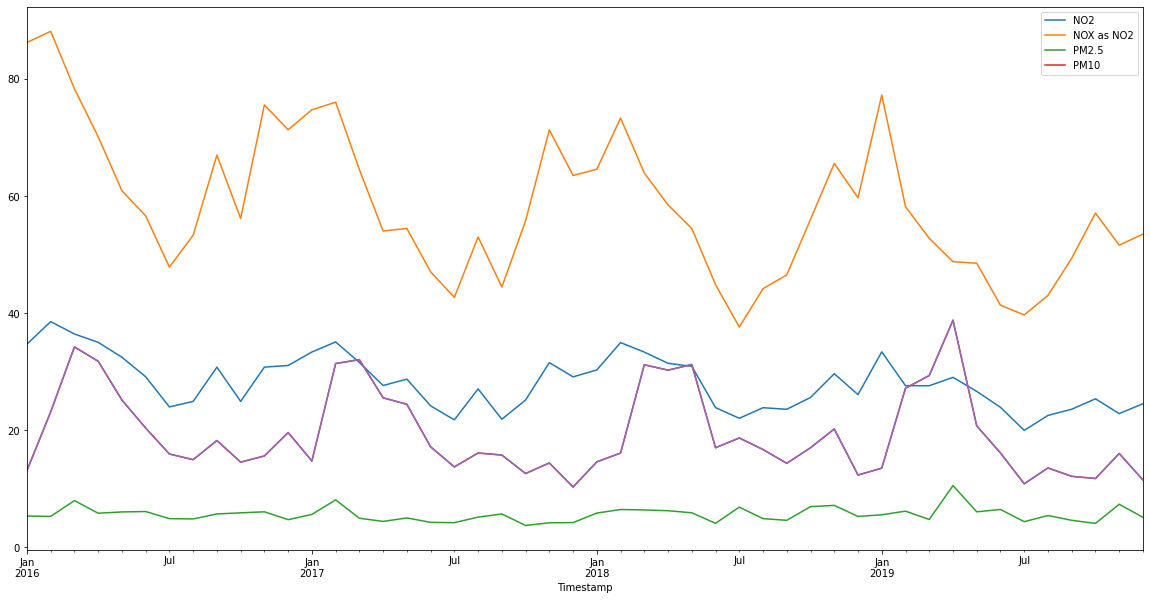

In [14]:
# pm 10 timeseries
plot_data = AirData_2[['Timestamp', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
plot_data = plot_data.set_index("Timestamp")
plot_data_resample = plot_data.resample(rule = "M").mean().ffill()
plot_data_resample.plot(figsize = (20,10))
plot_data_resample['PM10'].plot(figsize = (20,10))

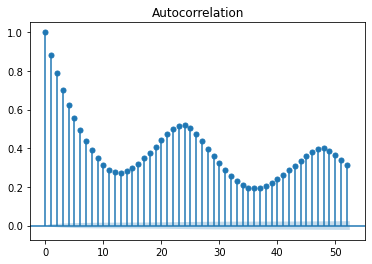

In [15]:
# autocorrelation plot V_t1 to V_t50 
plot_acf(plot_data['PM10'].dropna())
plt.show()

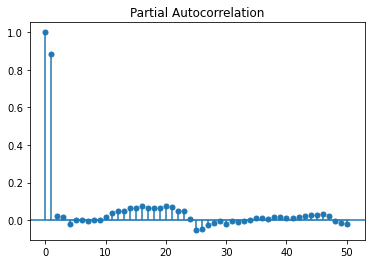

In [16]:
# partialautocorrelation plot V_t1 to V_t50 
plot_pacf(plot_data['PM10'].dropna(), lags=50)
plt.show()

## 3) Outliers Removal

In [17]:
# Generating weektype from day of week
AirData_2['Weektype'] = pd.DatetimeIndex(AirData_2['Timestamp']).dayofweek
# Replace weedays labels WeekDays and WeekEnds 
AirData_2['Weektype'] = AirData_2['Weektype'].replace([0, 1, 2, 3, 4], 'WeekDay')
AirData_2['Weektype'] = AirData_2['Weektype'].replace([5, 6], 'WeekEnd')
print(AirData_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371804
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   NO2             138724 non-null  float64       
 4   NOX as NO2      138910 non-null  float64       
 5   PM2.5           132235 non-null  float64       
 6   PM10            135122 non-null  float64       
 7   Weektype        140252 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 9.6+ MB
None


In [18]:
# Generating Hour class 'Transition', 'Night', 'Traffic', 'Peak'
AirData_2 = AirData_2.assign(Hour=pd.cut(AirData_2['Timestamp'].dt.hour,[0,1,5,6,9,16,20,22,24],labels=['Transition','Night','Transition','Traffic','Peak','Traffic','Peak','Transition'],ordered=False))
# Replace timestamp 00:00 with Transition
AirData_2['Hour'] = AirData_2['Hour'].fillna('Transition')
AirData_2['Hour'] = AirData_2.Hour.astype(str)

In [19]:
AirData_2.groupby(['Classification','Weektype','Hour']).count().drop(['Timestamp'],1)

Station Name    NO2  NOX as NO2  PM2.5  \
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night               1672   1657        1658   1545   
                          Peak                3762   3745        3745   3481   
                          Traffic             2926   2912        2912   2709   
                          Transition          1672   1662        1663   1547   
                 WeekEnd  Night               4172   4131        4131   3859   
                          Peak                9387   9282        9282   8692   
                          Traffic             7301   7222        7222   6764   
                          Transition          4171   4131        4131   3861   
Urban Traffic    WeekDay  Night               5016   4907        4924   4779   
                          Peak               11286  11201       11220  10701   
                          Traffic             8778   8711        8727   8361   
                          Transition          5016   4972        4988   4802   
                 WeekEnd  Night              12516  12256       12308  11920   
                          Peak               28161  27858       27888  26516   
                          Traffic            21903  21677       21694  20777   
                          Transition         12513  12400       12417  11921   

                                       PM10  
Classification   Weektype Hour               
Urban Background WeekDay  Night        1645  
                          Peak         3685  
                          Traffic      2863  
                          Transition   1646  
                 WeekEnd  Night        4050  
                          Peak         9036  
                          Traffic      7064  
                          Transition   4048  
Urban Traffic    WeekDay  Night        4842  
                          Peak        10873  
                          Traffic      8471  
                          Transition   4849  
                 WeekEnd  Night       12062  
                          Peak        26884  
                          Traffic     21048  
                          Transition  12056

In [20]:
AirData_2.groupby(['Classification','Weektype','Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.5    4.5   94.2        0.9    5.3   
                          Peak        0.5    5.9   81.1        1.4    7.3   
                          Traffic     0.3    5.7   70.1        1.0    6.9   
                          Transition  0.4    5.6   91.3        0.9    6.5   
                 WeekEnd  Night       0.3    4.3   70.9        0.5    5.1   
                          Peak        0.9   10.2   83.7        1.6   12.5   
                          Traffic     0.7   12.6   92.2        1.3   14.6   
                          Transition  0.4    6.1   82.8        1.1    7.0   
Urban Traffic    WeekDay  Night       0.6   15.6  120.8        1.9   23.5   
                          Peak        2.0   27.7  130.1        2.8   51.1   
                          Traffic     0.6   23.7  158.8        1.3   40.1   
                          Transition  1.0   20.2  121.6        1.0   31.7   
                 WeekEnd  Night       0.3   12.9   98.8        0.1   19.8   
                          Peak        2.0   41.5  180.2        2.1   87.7   
                          Traffic     2.4   42.6  212.8        2.6   87.8   
                          Transition  0.8   20.2  121.9        0.9   33.1   

                                            PM2.5               PM10         \
                                        max   min median    max  min median   
Classification   Weektype Hour                                                
Urban Background WeekDay  Night       237.4   0.4    3.6   39.0 -3.0    7.7   
                          Peak        165.2   0.2    3.3   59.3 -2.8    8.7   
                          Traffic     239.5   0.3    3.4   54.5 -3.0    8.6   
                          Transition  159.0   0.2    3.8   47.6 -1.8    8.2   
                 WeekEnd  Night       118.6   0.1    3.4   34.7 -3.0    7.4   
                          Peak        647.0   0.3    3.4   38.6 -2.9   10.7   
                          Traffic     341.8   0.2    3.6   36.0 -3.0   10.7   
                          Transition  155.5   0.2    3.5   36.5 -2.9    8.4   
Urban Traffic    WeekDay  Night       371.8  -3.0    4.5   42.0 -1.1   11.4   
                          Peak        375.8  -3.0    4.8  105.0 -1.8   15.5   
                          Traffic     488.6  -3.0    4.8   57.8 -2.5   13.5   
                          Transition  379.9  -3.0    5.1   72.4 -2.2   12.9   
                 WeekEnd  Night       573.4  -3.0    3.9   39.3 -2.9   10.3   
                          Peak        926.8  -3.0    5.4   80.1 -2.2   20.2   
                          Traffic     882.0  -3.0    5.5   61.6 -2.9   18.9   
                          Transition  982.5  -3.0    4.6   71.2 -3.0   13.0   

                                             
                                        max  
Classification   Weektype Hour               
Urban Background WeekDay  Night        69.6  
                          Peak        140.4  
                          Traffic      94.0  
                          Transition   71.8  
                 WeekEnd  Night        73.3  
                          Peak        162.6  
                          Traffic     148.0  
                          Transition   76.9  
Urban Traffic    WeekDay  Night       208.1  
                          Peak        261.6  
                          Traffic     219.0  
                          Transition  186.8  
                 WeekEnd  Night       173.4  
                          Peak        324.8  
                          Traffic     365.1  
                          Transition  297.9

### IQR Method

In [21]:
# removing Outliers
Q1 = AirData_2['PM10'].quantile(0.25)
Q3 = AirData_2['PM10'].quantile(0.75)
IQR = Q3 - Q1 
IQR
Outlier_filter = (AirData_2['PM10'] >= Q1 - 1.5 * IQR) & (AirData_2['PM10'] <= Q3 + 1.5 * IQR)
#otemp = temp.loc[Outlier_filter]
print(Q1 - 0.75 * IQR)
print(Q3 + 4.4 *IQR)

-2.8249999999999993
87.58000000000001


In [22]:
cfilt = list(AirData_2['Classification'].unique())
wfilt = list(AirData_2['Weektype'].unique())
hfilt = list(AirData_2['Hour'].unique())

AirData_3 = pd.DataFrame(columns = ['Timestamp', 'Station Name', 'Classification','Weektype', 'Hour', 'NO2', 'NOX as NO2',
       'PM2.5', 'PM10'])

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            print(len(AirData_2.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')))
            temp = AirData_2.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            
            # removing Outliers
            Q1 = temp['PM2.5'].quantile(0.25)
            Q3 = temp['PM2.5'].quantile(0.75)
            IQR = Q3 - Q1 
            IQR
            Outlier_filter = (temp['PM2.5'] >= Q1 - 1.5 * IQR) & (temp['PM2.5'] <= Q3 + 1.5 * IQR)
            temp = temp.loc[Outlier_filter]

            Q1 = temp['PM10'].quantile(0.25)
            Q3 = temp['PM10'].quantile(0.75)
            IQR = Q3 - Q1 
            Outlier_filter = (temp['PM10'] >= Q1 - 1.5 * IQR) & (temp['PM10'] <= Q3 + 1.5 *IQR)
            temp = temp.loc[Outlier_filter]

            Q1 = temp['NO2'].quantile(0.25)
            Q3 = temp['NO2'].quantile(0.75)
            IQR = Q3 - Q1 
            Outlier_filter = (temp['NO2'] >= Q1 - 1.5 * IQR) & (temp['NO2'] <= Q3 + 1.5 *IQR)
            temp = temp.loc[Outlier_filter]  

            Q1 = temp['NOX as NO2'].quantile(0.25)
            Q3 = temp['NOX as NO2'].quantile(0.75)
            IQR = Q3 - Q1 
            Outlier_filter = (temp['NOX as NO2'] >= Q1 - 1.5 * IQR) & (temp['NOX as NO2'] <= Q3 + 1.5 *IQR)
            temp = temp.loc[Outlier_filter]    
            AirData_3 = AirData_3.append(temp)
            print('Appended\n')
            
print("Saving File")
savePath = r"G:\Uppsala Docs\period5&6\ProcessedData"
AirData_3.to_csv(savePath+"\\"+'2016-2019_SensorData_Outlier_Removed.csv')

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Transition"
12513
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Night"
12516
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Traffic"
21903
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Peak"
28161
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"
5016
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Night"
5016
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Traffic"
8778
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Peak"
11286
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Transition"
4171
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" & Hour == "Night"
4172
Appended

Classification == "Urban Background" & Weektype == "WeekEnd" &

In [23]:
AirData_3.info() #1074843

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107484 entries, 52242 to 371755
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       107484 non-null  datetime64[ns]
 1   Station Name    107484 non-null  object        
 2   Classification  107484 non-null  object        
 3   Weektype        107484 non-null  object        
 4   Hour            107484 non-null  category      
 5   NO2             107484 non-null  float64       
 6   NOX as NO2      107484 non-null  float64       
 7   PM2.5           107484 non-null  float64       
 8   PM10            107484 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(4), object(3)
memory usage: 7.5+ MB


In [24]:
AirData_3.groupby(['Classification','Weektype','Hour']).count().drop(['Timestamp'],1)

Station Name    NO2  NOX as NO2  PM2.5  \
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night               1251   1251        1251   1251   
                          Peak                2664   2664        2664   2664   
                          Traffic             2115   2115        2115   2115   
                          Transition          1280   1280        1280   1280   
                 WeekEnd  Night               3012   3012        3012   3012   
                          Peak                6706   6706        6706   6706   
                          Traffic             5362   5362        5362   5362   
                          Transition          3125   3125        3125   3125   
Urban Traffic    WeekDay  Night               3998   3998        3998   3998   
                          Peak                8661   8661        8661   8661   
                          Traffic             6748   6748        6748   6748   
                          Transition          4047   4047        4047   4047   
                 WeekEnd  Night               9903   9903        9903   9903   
                          Peak               21609  21609       21609  21609   
                          Traffic            17004  17004       17004  17004   
                          Transition          9999   9999        9999   9999   

                                       PM10  
Classification   Weektype Hour               
Urban Background WeekDay  Night        1251  
                          Peak         2664  
                          Traffic      2115  
                          Transition   1280  
                 WeekEnd  Night        3012  
                          Peak         6706  
                          Traffic      5362  
                          Transition   3125  
Urban Traffic    WeekDay  Night        3998  
                          Peak         8661  
                          Traffic      6748  
                          Transition   4047  
                 WeekEnd  Night        9903  
                          Peak        21609  
                          Traffic     17004  
                          Transition   9999

In [25]:
AirData_3.groupby(['Classification','Weektype','Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.5    4.0   12.2        0.9    4.8   
                          Peak        0.6    5.0   15.4        1.5    6.3   
                          Traffic     0.3    4.9   16.7        1.0    6.0   
                          Transition  0.4    5.0   15.6        0.9    5.9   
                 WeekEnd  Night       0.3    3.8   11.6        0.8    4.6   
                          Peak        1.5    8.9   30.2        2.3   11.1   
                          Traffic     0.9   11.1   38.1        1.7   13.1   
                          Transition  0.4    5.5   17.2        1.1    6.4   
Urban Traffic    WeekDay  Night       0.6   14.1   45.8        1.9   20.9   
                          Peak        2.0   25.7   67.7        2.8   46.8   
                          Traffic     0.6   20.9   66.8        1.3   34.9   
                          Transition  1.0   18.2   56.5        1.0   28.4   
                 WeekEnd  Night       0.3   11.8   38.8        0.8   18.0   
                          Peak        2.0   38.8   99.0        2.1   80.0   
                          Traffic     2.4   39.4  100.3        2.6   79.9   
                          Transition  0.8   18.8   55.3        0.9   30.4   

                                            PM2.5              PM10         \
                                        max   min median   max  min median   
Classification   Weektype Hour                                               
Urban Background WeekDay  Night        12.9   0.4    3.2  12.3 -3.0    7.0   
                          Peak         16.3   0.2    2.8  10.8 -2.8    7.7   
                          Traffic      17.7   0.3    3.0  11.2 -3.0    7.6   
                          Transition   16.3   0.2    3.3  12.4 -1.8    7.6   
                 WeekEnd  Night        12.4   0.1    2.8  11.6 -3.0    6.5   
                          Peak         32.0   0.3    3.0  10.7 -2.9    9.6   
                          Traffic      40.2   0.2    3.1  11.2 -3.0    9.5   
                          Transition   18.0   0.2    3.1  12.0 -2.9    7.5   
Urban Traffic    WeekDay  Night        75.8  -3.0    4.0  14.6 -1.1   10.4   
                          Peak        137.3  -3.0    4.2  15.0 -0.9   13.7   
                          Traffic     123.0  -3.0    4.2  14.7 -0.9   11.9   
                          Transition   98.4  -3.0    4.6  15.8 -1.7   11.5   
                 WeekEnd  Night        62.5  -3.0    3.5  13.5 -2.9    9.4   
                          Peak        259.2  -3.0    4.9  15.9 -2.2   18.1   
                          Traffic     256.7  -3.0    5.1  15.9 -2.9   17.1   
                          Transition   98.3  -3.0    4.1  15.0 -3.0   11.8   

                                            
                                       max  
Classification   Weektype Hour              
Urban Background WeekDay  Night       19.1  
                          Peak        22.6  
                          Traffic     21.9  
                          Transition  20.4  
                 WeekEnd  Night       19.3  
                          Peak        29.2  
                          Traffic     28.0  
                          Transition  22.1  
Urban Traffic    WeekDay  Night       29.8  
                          Peak        47.4  
                          Traffic     39.4  
                          Transition  34.5  
                 WeekEnd  Night       28.2  
                          Peak        64.0  
                          Traffic     55.8  
                          Transition  36.5

In [159]:
AirData_2.groupby(['Classification','Weektype','Hour']).aggregate(['min', np.median, 'max'])

NO2              NOX as NO2         \
                                      min median   max        min median   
Classification   Weektype Hour                                             
Urban Background WeekDay  Night       0.0    4.4  56.9        0.0   5.20   
                          Peak        0.0    5.8  60.6        0.0   7.20   
                          Traffic     0.0    5.7  59.4        0.0   6.80   
                          Transition  0.0    5.6  55.0        0.0   6.45   
                 WeekEnd  Night       0.0    4.2  67.9        0.0   5.00   
                          Peak        0.0   10.0  70.0        0.0  12.30   
                          Traffic     0.0   12.4  71.7        0.0  14.30   
                          Transition  0.0    6.0  67.0        0.0   6.90   
Urban Traffic    WeekDay  Night       0.0   15.1  71.4        0.0  22.90   
                          Peak        0.0   26.3  84.3        0.0  48.20   
                          Traffic     0.0   22.2  82.7        0.0  37.60   
                          Transition  0.0   19.6  73.9        0.0  30.90   
                 WeekEnd  Night       0.0   12.5  77.6        0.0  19.40   
                          Peak        0.0   35.4  86.0        0.0  70.70   
                          Traffic     0.0   36.3  87.0        0.0  70.40   
                          Transition  0.0   19.7  83.5        0.0  32.15   

                                            PM2.5              PM10         \
                                        max   min median   max  min median   
Classification   Weektype Hour                                               
Urban Background WeekDay  Night        96.3   0.0    3.3  16.8 -3.0    7.4   
                          Peak         97.8   0.0    2.9  17.9 -2.8    8.3   
                          Traffic     125.2   0.0    3.1  17.5 -3.0    8.3   
                          Transition   95.9   0.0    3.4  17.4 -1.8    8.0   
                 WeekEnd  Night       118.6   0.0    3.0  18.2 -3.0    7.1   
                          Peak        190.1   0.0    3.1  19.6 -2.9   10.2   
                          Traffic     183.9   0.0    3.2  19.0 -3.0   10.1   
                          Transition  155.5   0.0    3.1  18.1 -2.9    8.0   
Urban Traffic    WeekDay  Night       186.0  -3.0    4.1  18.2 -1.1   10.8   
                          Peak        204.1  -3.0    4.2  19.3 -1.8   13.9   
                          Traffic     217.8  -2.9    4.3  18.8 -2.5   12.4   
                          Transition  193.8  -3.0    4.6  18.5 -2.2   11.9   
                 WeekEnd  Night       206.3  -3.0    3.6  18.7 -2.9    9.7   
                          Peak        225.3  -3.0    4.6  19.4 -2.2   17.2   
                          Traffic     220.2  -3.0    4.9  20.0 -2.9   16.6   
                          Transition  206.8  -3.0    4.2  18.8 -3.0   12.0   

                                            
                                       max  
Classification   Weektype Hour              
Urban Background WeekDay  Night       46.5  
                          Peak        46.4  
                          Traffic     49.0  
                          Transition  45.1  
                 WeekEnd  Night       50.6  
                          Peak        68.4  
                          Traffic     67.8  
                          Transition  57.8  
Urban Traffic    WeekDay  Night       74.2  
                          Peak        75.6  
                          Traffic     75.8  
                          Transition  75.0  
                 WeekEnd  Night       73.1  
                          Peak        76.1  
                          Traffic     75.4  
                          Transition  73.0

In [68]:
temp = AirData_2.query('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
print('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
temp.info()

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Transition"
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12513 entries, 52237 to 363044
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       12513 non-null  datetime64[ns]
 1   Station Name    12513 non-null  object        
 2   Classification  12513 non-null  object        
 3   NO2             12400 non-null  float64       
 4   NOX as NO2      12417 non-null  float64       
 5   PM2.5           11921 non-null  float64       
 6   PM10            12056 non-null  float64       
 7   Weektype        12513 non-null  object        
 8   Hour            12513 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(4), object(3)
memory usage: 892.2+ KB


In [69]:
temp.groupby(['Classification','Weektype','Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                    min median    max        min median   
Classification Weektype Hour                                              
Urban Traffic  WeekEnd  Night       NaN    NaN    NaN        NaN    NaN   
                        Peak        NaN    NaN    NaN        NaN    NaN   
                        Traffic     NaN    NaN    NaN        NaN    NaN   
                        Transition  0.8   20.2  121.9        0.9   33.1   

                                          PM2.5              PM10         \
                                      max   min median   max  min median   
Classification Weektype Hour                                               
Urban Traffic  WeekEnd  Night         NaN   NaN    NaN   NaN  NaN    NaN   
                        Peak          NaN   NaN    NaN   NaN  NaN    NaN   
                        Traffic       NaN   NaN    NaN   NaN  NaN    NaN   
                        Transition  982.5  -3.0    4.6  71.2 -3.0   13.0   

                                           
                                      max  
Classification Weektype Hour               
Urban Traffic  WeekEnd  Night         NaN  
                        Peak          NaN  
                        Traffic       NaN  
                        Transition  297.9

E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':
E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

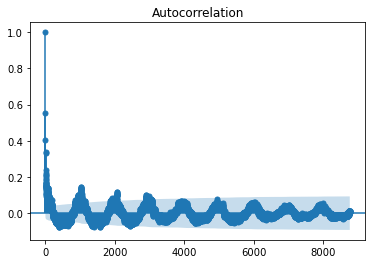

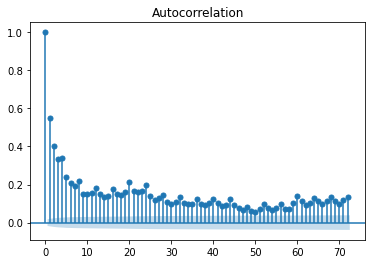

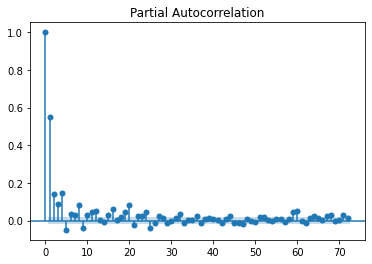

In [70]:
# slice data
plot_data = temp[['Timestamp', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
plot_data = plot_data.set_index("Timestamp")

# autocorrelation plot for 365 days
f1 = plt.figure(1)
plot_acf(plot_data['PM10'].dropna(), lags=8760)
f1.show()
# autocorrelation plot for 2 days
f2 = plt.figure(2)
plot_acf(plot_data['PM10'].dropna(), lags=72)
f2.show()
# partialautocorrelation plot for 2 days 
f3 = plt.figure(3)
plot_pacf(plot_data['PM10'].dropna(), lags=72)
f3.show()

<AxesSubplot:xlabel='Timestamp'>

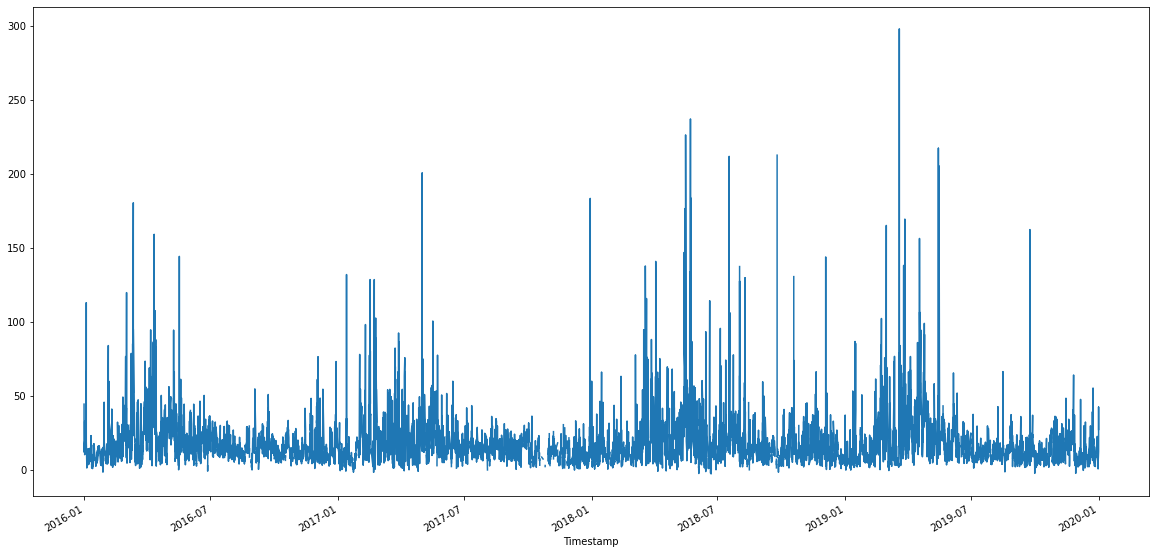

In [71]:
# time series
plot_data['PM10'].plot(figsize = (20,10))

In [72]:
AirData_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371804
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   NO2             138724 non-null  float64       
 4   NOX as NO2      138910 non-null  float64       
 5   PM2.5           132235 non-null  float64       
 6   PM10            135122 non-null  float64       
 7   Weektype        140252 non-null  object        
 8   Hour            140252 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(4), object(3)
memory usage: 14.8+ MB


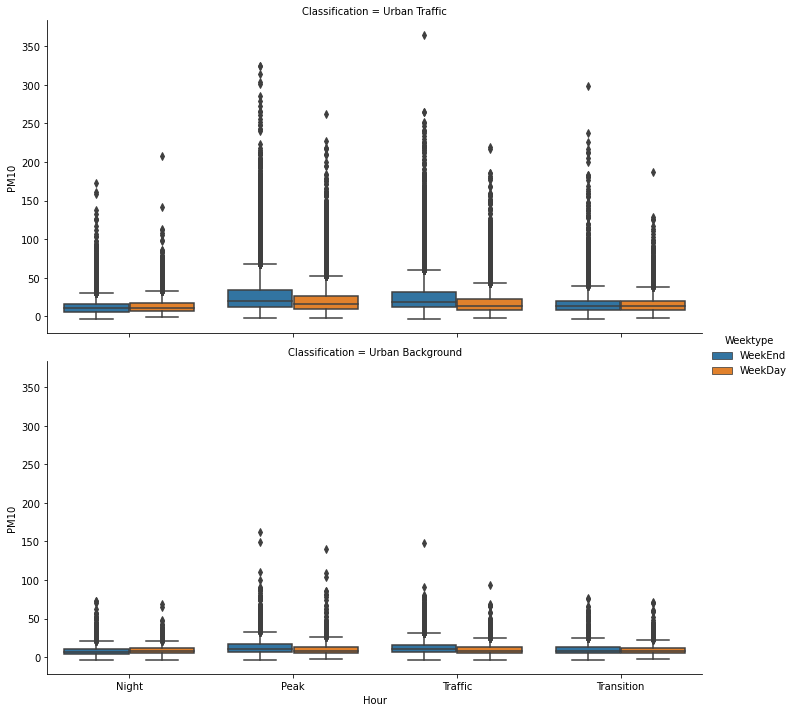

In [73]:
sns.catplot(x='Hour', y='PM10', kind='box',
            hue='Weektype' , row='Classification', 
            aspect=2 ,data=AirData_2)

<AxesSubplot:xlabel='Timestamp'>

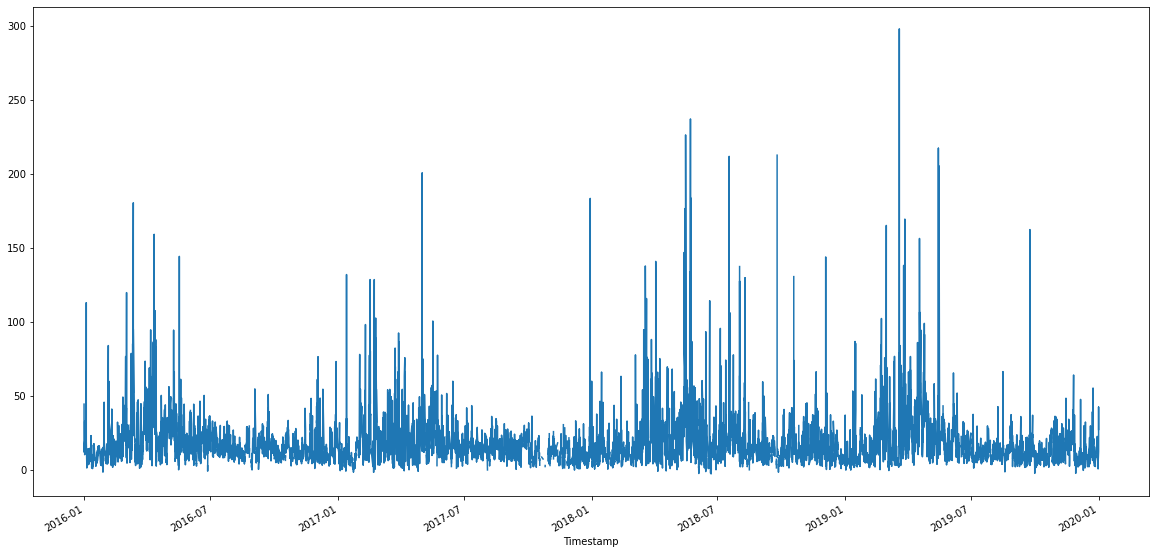

In [74]:
# time series
plot_data['PM10'].plot(figsize = (20,10))

In [98]:
Mean = plot_data.mean()
Std = plot_data.std()
h_Limit = Mean + 3*np.sqrt(Std)
l_Limit = Mean - 3*np.sqrt(Std)
print('Mean:\n'+str(Mean))
print('Standard Deviation:\n'+str(Std))
print('Low Threshold:\n'+str(l_Limit))
print('High Threshold:\n'+str(h_Limit))

Mean:
NO2           23.765605
NOX as NO2    42.990279
PM2.5          5.618748
PM10          16.732930
dtype: float64
Standard Deviation:
NO2           15.198743
NOX as NO2    38.745718
PM2.5          4.796890
PM10          15.670252
dtype: float64
Low Threshold:
NO2           12.069935
NOX as NO2    24.316462
PM2.5         -0.951793
PM10           4.857229
dtype: float64
High Threshold:
NO2           35.461274
NOX as NO2    61.664097
PM2.5         12.189290
PM10          28.608630
dtype: float64


<AxesSubplot:xlabel='Timestamp'>

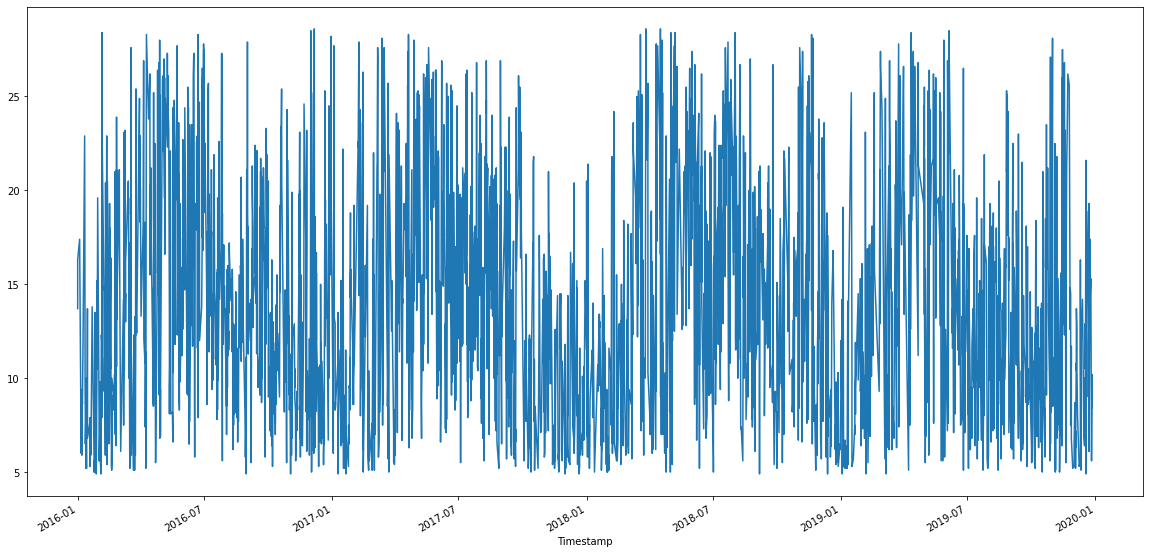

In [99]:
plot_data[((plot_data > l_Limit).all(1) & (plot_data < h_Limit).all(1))]['PM10'].plot(figsize = (20,10))

In [106]:
AirData_2['PM10'].rolling(4).sum()

52237      NaN
52238      NaN
52239      NaN
52240     90.2
52241     60.2
          ... 
371800    36.2
371801    30.9
371802    25.0
371803    21.8
371804    16.7
Name: PM10, Length: 140252, dtype: float64

In [110]:
AirData_2['PM10']#.isnull().sum()

52237     44.2
52238     17.5
52239     15.4
52240     13.1
52241     14.2
          ... 
371800     7.9
371801     6.4
371802     4.5
371803     3.0
371804     2.8
Name: PM10, Length: 140252, dtype: float64

array([[<AxesSubplot:title={'center':'NO2'}>,
        <AxesSubplot:title={'center':'NOX as NO2'}>],
       [<AxesSubplot:title={'center':'PM2.5'}>,
        <AxesSubplot:title={'center':'PM10'}>]], dtype=object)

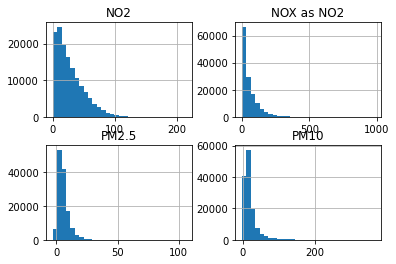

In [114]:
AirData_2.hist(bins=30).plot(figsize = (10,10))

<AxesSubplot:ylabel='Density'>

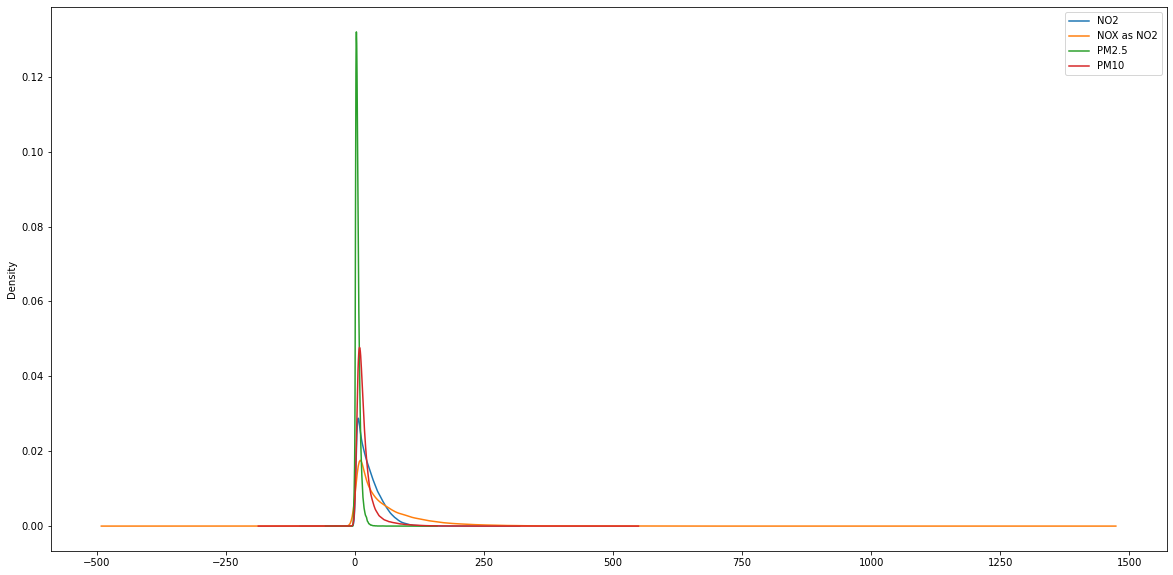

In [118]:
AirData_2[['NO2','NOX as NO2','PM2.5','PM10']].plot.kde(figsize = (20,10))

In [135]:

AirData_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140252 entries, 52237 to 371804
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Timestamp       140252 non-null  datetime64[ns]
 1   Station Name    140252 non-null  object        
 2   Classification  140252 non-null  object        
 3   NO2             138724 non-null  float64       
 4   NOX as NO2      138910 non-null  float64       
 5   PM2.5           132235 non-null  float64       
 6   PM10            135122 non-null  float64       
 7   Weektype        140252 non-null  object        
 8   Hour            140252 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 15.7+ MB


In [139]:
AirData_2.fillna(0,inplace=True)
#specify the 12 metrics column names to be modelled
to_model_columns=AirData_2.columns[3:7]
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(AirData_2[to_model_columns])
pred = clf.predict(AirData_2[to_model_columns])


In [144]:
AirData_2['anomaly']=pred
outliers=AirData_2.loc[AirData_2['anomaly']==-1]
outlier_index=list(outliers.index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(AirData_2['anomaly'].value_counts())

 1    123421
-1     16831
Name: anomaly, dtype: int64


In [156]:
AirData_2 = AirData_2.loc[AirData_2['anomaly']==1]
AirData_2 = AirData_2.drop('anomaly',1)

In [157]:
temp = AirData_2.query('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
print('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
temp.info()

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Transition"
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11780 entries, 52242 to 363044
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       11780 non-null  datetime64[ns]
 1   Station Name    11780 non-null  object        
 2   Classification  11780 non-null  object        
 3   NO2             11780 non-null  float64       
 4   NOX as NO2      11780 non-null  float64       
 5   PM2.5           11780 non-null  float64       
 6   PM10            11780 non-null  float64       
 7   Weektype        11780 non-null  object        
 8   Hour            11780 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 920.3+ KB


<AxesSubplot:xlabel='Timestamp'>

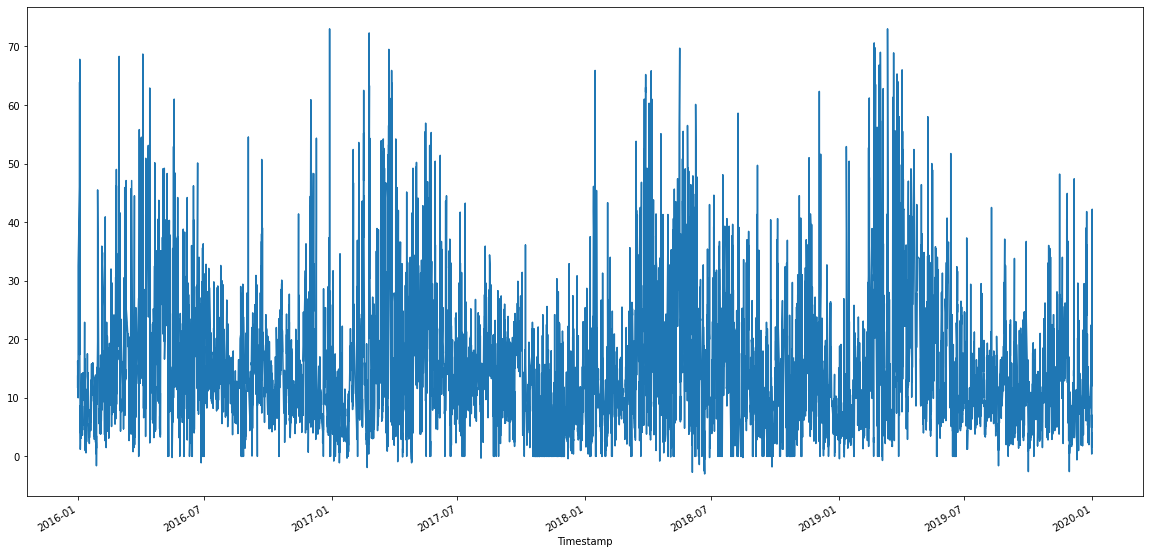

In [158]:
# slice data
plot_data = temp[['Timestamp', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
plot_data = plot_data.set_index("Timestamp")
# time series
plot_data['PM10'].plot(figsize = (20,10))

E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Programs\Anaconda\envs\damp\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

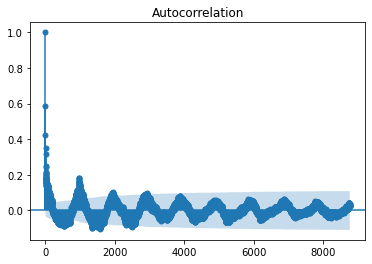

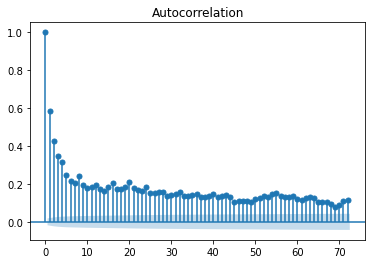

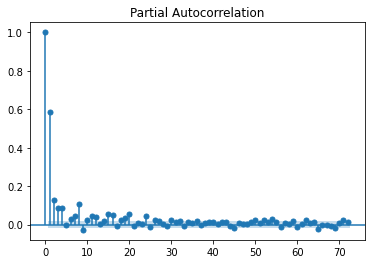

In [160]:
# autocorrelation plot for 365 days
f1 = plt.figure(1)
plot_acf(plot_data['PM10'].dropna(), lags=8760)
f1.show()
# autocorrelation plot for 2 days
f2 = plt.figure(2)
plot_acf(plot_data['PM10'].dropna(), lags=72)
f2.show()
# partialautocorrelation plot for 2 days 
f3 = plt.figure(3)
plot_pacf(plot_data['PM10'].dropna(), lags=72)
f3.show()

KeyboardInterrupt: 

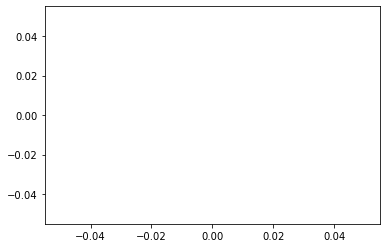

In [174]:
sns.lineplot(data=AirData_2, x="Timestamp", y="NO2")

In [177]:
AirData_3.columns[5:9]

Index(['NO2', 'NOX as NO2', 'PM2.5', 'PM10'], dtype='object')

In [180]:
len(outlier_index)

16831